# IEEE 30-Bus TD-OPF Simulation Visualisation

This notebook visualises the results of Temperature-Dependent Optimal
Power Flow (TD-OPF) experiments on the IEEE 30-bus test system.

**Contents**
1. Configuration — scenarios, analysis methods, and colour palette
2. Data loading helpers
3. Plotting utilities (grouped bar, grouped violin, single bar)
4. Sensitivity analysis across load scenarios
5. Computational cost comparison
6. Weather-scenario analysis

## 1. Imports

In [15]:
import os
import sys

cur_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(os.getcwd(), ".."))

from data_config import *
from utils.plot_utils import *

## 2. Configuration

In [ ]:
# ---------------------------------------------------------------------------
# System
# ---------------------------------------------------------------------------
nbus = 30

# ---------------------------------------------------------------------------
# Scenarios
# ---------------------------------------------------------------------------
Load_scenario = [0.8, 0.9, 1.0]  # light / default / heavy load

# (wind_speed m/s, air_temperature °C)
Weather_scenario = [
    (0.61, 25),   # mild weather
    (0.10, 25),   # mild + low wind
    (0.61, 45),   # mild + high temperature
    (0.10, 45),   # extreme weather
]

scenario_list = {
    'Mild':    Weather_scenario[0],
    'Extreme': Weather_scenario[-1],
}

load_ratio_list = {
    'Light':   Load_scenario[0],
    'Medium': Load_scenario[1],
    'Default':   Load_scenario[2],
}

# ---------------------------------------------------------------------------
# Analysis methods
# ---------------------------------------------------------------------------
analysis_list = [
    'base',                # AC-OPF
    'td_quad',             # Quad-OPF
    'td_derate_iter_2',    # Iter-OPF  (2 iterations)
    'td_derate_iter_10',   # TD-OPF    (10 iterations)
]

SA_list = [
    'base_derate',  # w/o thermal constraints
    'td_iter_2',    # w/o generator derating
    'base_acsc',    # AC security-constrained
    'base_dcsc',    # DC security-constrained
    'base_fixsc',   # Fixed security-constrained
]

analysis_list_label = {
    'base':               'AC-OPF',
    'td_quad':            'Quad-OPF',
    'td_derate_iter_2':   'Iter-OPF',
    'td_derate_iter_10':  'TD-OPF',
    'base_derate':        'w/o thermal',
    'td_iter_2':          'w/o derating',
    'base_acsc':          'AC-SC-OPF',
    'base_dcsc':          'DC-SC-OPF',
    'base_fixsc':         'Fixed-SC-OPF',
}

# ---------------------------------------------------------------------------
# Colour palette  (one colour per method)
# ---------------------------------------------------------------------------
colors_list = {
    'base':               '#72A9D0',  # Blue
    'td_quad':            '#8EC6C2',  # Mint
    'td_derate_iter_2':   '#F5B378',  # Peach
    'td_derate_iter_10':  '#E83947',  # Red
    'base_derate':        '#E86AAC',  # Pink
    'td_iter_2':          '#7952B3',  # Purple
    'base_acsc':          '#2E8B57',  # Green
    'base_dcsc':          '#A3D5DD',  # Cyan
    'base_fixsc':         '#78CC6B',  # Light green
}

# Visualisation settings
metric_list = ['load_shedding', 'mean_temperature']
vis_metric = metric_list[0]
mild_weather = scenario_list['Mild']
extreme_weather = scenario_list['Extreme']
max_conductor_temp = 90

## 3. Data Loading Helpers

In [17]:
def get_data(weather_scenario, load_ratio, analysis_list,
             max_conductor_temp=90):
    """Load OPF results for every method under one (weather, load) scenario.

    Returns:
        tuple: (load_shedding %, con_temp, line_current, run_time) arrays.
    """
    load_shedding_data = []
    con_temp_data = []
    line_current_data = []
    run_time_data = []

    exper_name = 'heatflow_analysis'
    record_path = cur_dir + f'/models/IEEE30/record/{exper_name}/'
    wind_speed, air_temp = weather_scenario

    for tdpf_analysis in analysis_list:
        fname = (
            f'load_{load_ratio}_temp_{air_temp}_wind_{wind_speed}'
            f'_{tdpf_analysis}_maxtemp_{max_conductor_temp}.npy'
        )
        result = np.load(
            record_path + fname, allow_pickle=True
        ).item()

        load_shedding_data.append(
            np.sum(result['p_eq_vio']) / np.sum(result['PD'])
        )
        con_temp_data.append(result['con_temp'])
        line_current_data.append(result['S_pu'])
        run_time_data.append(result['runtime'])

    load_shedding_data = np.array(load_shedding_data) * 100
    con_temp_data = np.array(con_temp_data)
    line_current_data = np.array(line_current_data)
    run_time_data = np.array(run_time_data)

    return load_shedding_data, con_temp_data, line_current_data, run_time_data


def get_comp_cost_data(analysis_list):
    """Retrieve per-method running-time arrays from the summary CSV."""
    exper_name = 'heatflow_analysis'
    df_path = cur_dir + f'/models/IEEE30/{nbus}_{exper_name}.csv'
    df = pd.read_csv(df_path)

    compute_cost_data = []
    for tdpf_analysis in analysis_list:
        values = df.loc[
            df['TDPF_solver'] == tdpf_analysis, 'run_time'
        ].values
        compute_cost_data.append(values)

    return compute_cost_data

## 4. Plotting Utilities

In [22]:
def grouped_bar_plot(data_dict, year_list, scenario_labels, colors,
                    y_label, save_path, ratio=2.5, title=None,
                    label_rotation=0, scenario_color=None, bar_width=0.37):
    """Create a grouped bar plot with multiple scenarios per category.

    Parameters
    ----------
    data_dict : dict
        {scenario_label: (mean_array, std_array)} for all categories.
    year_list : list[str]
        X-axis category labels.
    scenario_labels : list[str]
        Legend entries (one per scenario group).
    colors : list[str]
        One colour per category.
    y_label : str
        Y-axis label.
    save_path : str
        Output PDF path.
    """
    plt.rcParams.update(fig_config)

    n_years = len(year_list)
    n_scenarios = len(scenario_labels)
    hatch_list = ['..', 'xx', '///', '+++'][:n_scenarios]

    # --- Figure -----------------------------------------------------------
    fig, ax = plt.subplots(
        1, 1, figsize=(min(n_years * n_scenarios * ratio, 20), 5)
    )
    ax.set_axisbelow(False)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.)
    ax.grid(axis='x', linestyle='--', linewidth=1, alpha=0.)
    x_pos = np.arange(n_years)

    total_width = bar_width * n_scenarios
    start = -total_width / 2 + bar_width / 2
    gap_list = [start + i * bar_width for i in range(n_scenarios)]

    # --- Bars -------------------------------------------------------------
    val_max = -np.inf
    for i, scenario in enumerate(scenario_labels):
        data_mean, data_std = data_dict[scenario]
        val_max = max(val_max, np.max(data_mean) + np.max(data_std))

        bars = ax.bar(
            x_pos + gap_list[i], data_mean, bar_width,
            color=colors, alpha=0.6 + i * 0.05, linewidth=0,
            hatch=hatch_list[i], edgecolor=(0, 0, 0, 0.6),
            label=scenario,
        )
        ax.errorbar(
            x_pos + gap_list[i], data_mean,
            yerr=[np.zeros_like(data_std), data_std],
            fmt='none', elinewidth=2, capsize=5, capthick=1.0,
            ecolor='gray', alpha=0.9,
        )
        ax.plot(
            x_pos + gap_list[i], data_mean, 'o',
            color='darkred', markersize=5,
            markeredgecolor='darkred', markeredgewidth=1.2,
        )

        # Value labels
        for j, bar in enumerate(bars):
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                data_mean[j] * 1.02,
                f'{data_mean[j]:.2f}',
                fontsize=16, fontweight='bold',
                ha='center', va='bottom', zorder=4,
            )

    # --- Legend ------------------------------------------------------------
    if scenario_color is None:
        scenario_color = colors[2]
    legend_elements = [
        Patch(facecolor=scenario_color, hatch=hatch_list[i],
              edgecolor='black', linewidth=0.1, label=scenario_labels[i])
        for i in range(n_scenarios)
    ]
    legend = ax.legend(
        handles=legend_elements, ncol=n_scenarios,
        title='', edgecolor='white',
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
    )
    legend.get_frame().set_alpha(0.99)
    for text in legend.get_texts():
        text.set_fontweight('bold')

    # --- Styling ----------------------------------------------------------
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(y_label, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(
        year_list, ha='center', fontweight='bold', rotation=label_rotation
    )
    ax.set_ylim(0, max(val_max * 1.1, 1))
    if title is not None:
        ax.set_title(title)
    plt.tick_params(
        axis='both', which='both',
        top=False, bottom=False, left=True, right=False,
    )
    for txt in ax.get_xticklabels():
        if txt.get_text() in ['Iter-OPF', '90°C\nCorrected']:
            txt.set_color('royalblue')
            break

    # --- Save -------------------------------------------------------------
    plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [23]:
def grouped_violin_plot(data_dict, group_list, scenario_labels, colors,
                       y_label, save_path, title=None, scenario_color=None,
                       temporal=False, ratio=2.5, label_rotation=0,
                       bar_width=0.37):
    """Create a grouped violin plot with multiple scenarios per category.

    Parameters
    ----------
    data_dict : dict
        {scenario_label: [array_per_group, ...]}.
    group_list : list[str]
        X-axis group labels.
    scenario_labels : list[str]
        Legend entries.
    colors : list[str]
        One colour per group.
    y_label : str
        Y-axis label.
    save_path : str
        Output PDF path.
    temporal : bool
        If True, overlay a mean trend line across groups.
    """
    plt.rcParams.update(fig_config)

    n_groups = len(group_list)
    n_scenarios = len(scenario_labels)
    violin_width = bar_width
    total_width = violin_width * n_scenarios
    start = -total_width / 2 + violin_width / 2
    offsets = [start + i * violin_width for i in range(n_scenarios)]
    hatch_list = ['..', 'xx', '///', '+++'][:n_scenarios]

    # --- Figure -----------------------------------------------------------
    fig, ax = plt.subplots(
        1, 1, figsize=(min(n_groups * n_scenarios * ratio, 20), 5)
    )
    ax.set_axisbelow(False)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.)
    ax.grid(axis='x', linestyle='--', linewidth=1, alpha=0.)
    x_pos = np.arange(n_groups)

    val_max = -np.inf
    val_min = np.inf
    group_means = np.zeros(n_groups)

    # --- Violins ----------------------------------------------------------
    for s_idx, scenario in enumerate(scenario_labels):
        data_arrays = data_dict[scenario]
        for g_idx in range(n_groups):
            data = np.asarray(data_arrays[g_idx])
            center = x_pos[g_idx] + offsets[s_idx]
            color = colors[g_idx]

            parts = ax.violinplot(
                [data], positions=[center],
                widths=violin_width * 0.9,
                showmeans=False, showmedians=False, showextrema=False,
            )
            for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor('black')
                pc.set_alpha(0.6 + s_idx * 0.05)
                pc.set_hatch(hatch_list[s_idx])

            # Whiskers and mean dot
            min_val, max_val, mean_val = data.min(), data.max(), data.mean()
            upper_bar_w = violin_width * 0.15
            ax.plot([center, center], [min_val, max_val],
                    color=color, linewidth=0.2)
            ax.plot([center - upper_bar_w, center + upper_bar_w],
                    [min_val, min_val], color='dimgray', linewidth=1.5)
            ax.plot([center - upper_bar_w, center + upper_bar_w],
                    [max_val, max_val], color='dimgray', linewidth=1.5)
            ax.plot(center, mean_val, 'o', color='darkred', markersize=5,
                    markeredgecolor='darkred', markeredgewidth=1.2)

            val_max = max(val_max, max_val)
            val_min = min(val_min, min_val)
            group_means[g_idx] += mean_val / n_scenarios

    # --- Optional trend line ----------------------------------------------
    if temporal:
        ax.plot(
            x_pos, group_means, ':', color='black', linewidth=2.5,
            alpha=0.75, markersize=8, markerfacecolor='white',
            markeredgecolor='darkblue', markeredgewidth=2,
            label='Mean', zorder=12,
        )

    # --- Reference lines --------------------------------------------------
    if 'Temperature' in y_label:
        ax.axhline(y=90, color='red', linestyle='--', linewidth=2, alpha=0.6)
        ax.text(
            0.0, 91, 'Thermal limit',
            transform=ax.get_yaxis_transform(),
            color='red', ha='left', va='bottom', alpha=0.75,
            multialignment='center', fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.0),
        )
    if 'Drop' in y_label:
        ax.axhline(y=70, color='blue', linestyle='--', linewidth=2, alpha=0.6)
        ax.text(
            0.0, 69, 'Security margin',
            transform=ax.get_yaxis_transform(),
            color='blue', ha='left', va='top', alpha=0.75,
            multialignment='center', fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.0),
        )

    # --- Legend ------------------------------------------------------------
    if scenario_color is None:
        scenario_color = colors[2]
    legend_elements = [
        Patch(facecolor=scenario_color, hatch=hatch_list[i],
              edgecolor='black', linewidth=0.1, label=scenario_labels[i])
        for i in range(n_scenarios)
    ]
    legend = ax.legend(
        handles=legend_elements, ncol=n_scenarios,
        title='', edgecolor='white',
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
    )
    legend.get_frame().set_alpha(0.99)
    for text in legend.get_texts():
        text.set_fontweight('bold')

    # --- Styling ----------------------------------------------------------
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(y_label, fontweight='bold')
    ax.set_xlabel('')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(
        group_list, rotation=label_rotation, ha='center', fontweight='bold'
    )
    if title is not None:
        ax.set_title(title)

    # Y-limits
    if 'Load Shedding' in y_label:
        ax.set_ylim(0, max(val_max * 1.1, 0.01))
    elif 'Line Temperature' in y_label:
        ax.set_ylim(val_min * 0.9, max(val_max * 1.1, 95))
    elif 'Capacity Drop' in y_label:
        pass
    else:
        margin = (val_max - val_min) * 0.1 if val_max > val_min else 1.0
        ax.set_ylim(val_min - margin, val_max + margin)

    plt.tick_params(
        axis='both', which='both',
        top=False, bottom=False, left=True, right=False,
    )
    for txt in ax.get_xticklabels():
        if txt.get_text() in ['Iter-OPF', '90°C\nCorrected']:
            txt.set_color('royalblue')
            break

    # --- Save -------------------------------------------------------------
    plt.savefig(save_path, format='pdf', dpi=500, bbox_inches='tight')
    plt.show()
    plt.close()

In [29]:
def single_bar_plot(data_list, model_list, colors, y_label, save_path,
                   ratio=2.5, label_rotation=0, scale=None, ylim=None,
                   text_above=True, title=None):
    """Create a single-group bar plot with error bars and value labels.

    Parameters
    ----------
    data_list : list[array]
        One array of observations per model.
    model_list : list[str]
        Bar labels.
    colors : list[str]
        One colour per bar.
    y_label : str
        Y-axis label.
    save_path : str
        Output PDF path.
    """
    plt.rcParams.update(fig_config)

    # --- Figure -----------------------------------------------------------
    fig, ax = plt.subplots(
        1, 1, figsize=((len(model_list) // 5 + 1) * 10, 5)
    )
    ax.set_axisbelow(False)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.)
    ax.grid(axis='x', linestyle='--', linewidth=1, alpha=0.)
    x = np.arange(len(model_list))

    # --- Bars & error bars ------------------------------------------------
    data_mean = [np.mean(d) for d in data_list]
    data_std = [np.std(d) for d in data_list]
    bars = ax.bar(x, data_mean, alpha=0.9, color=colors)
    ax.errorbar(
        x, data_mean, yerr=data_std, fmt='none',
        elinewidth=1.5, capsize=14, capthick=2, ecolor='dimgray',
    )

    # --- Value labels -----------------------------------------------------
    ax.scatter(x, data_mean, marker='o', color='darkred', s=40, zorder=3)
    for i, bar in enumerate(bars):
        if data_mean[i] > 1e-2 and text_above:
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                data_mean[i] + data_std[i] * 1.01,
                f'ave:{data_mean[i]:.2f}',
                fontsize=16, fontweight='bold',
                ha='center', va='bottom', zorder=4,
            )

    # --- Styling ----------------------------------------------------------
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if scale == 'log':
        ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim(0, np.max(data_mean) + np.max(data_std) * 1.1)
    ax.set_ylabel(y_label, fontweight='bold')
    ax.set_xlabel('')
    ax.set_xticks(x)
    ax.set_xticklabels(
        model_list, rotation=label_rotation, ha='center', fontweight='bold'
    )
    if title is not None:
        ax.set_title(title)
    plt.tick_params(
        axis='both', which='both',
        top=False, bottom=False, left=True, right=False,
    )
    for txt in ax.get_xticklabels():
        if txt.get_text() in ['Iter-OPF', '90°C\nCorrected']:
            txt.set_color('royalblue')
            break

    # --- Save -------------------------------------------------------------
    plt.savefig(save_path, format='pdf', bbox_inches='tight')

## 5. Sensitivity Analysis — Load Scenarios

For each load ratio (light / default / heavy), compare all analysis
methods under mild vs. extreme weather conditions.

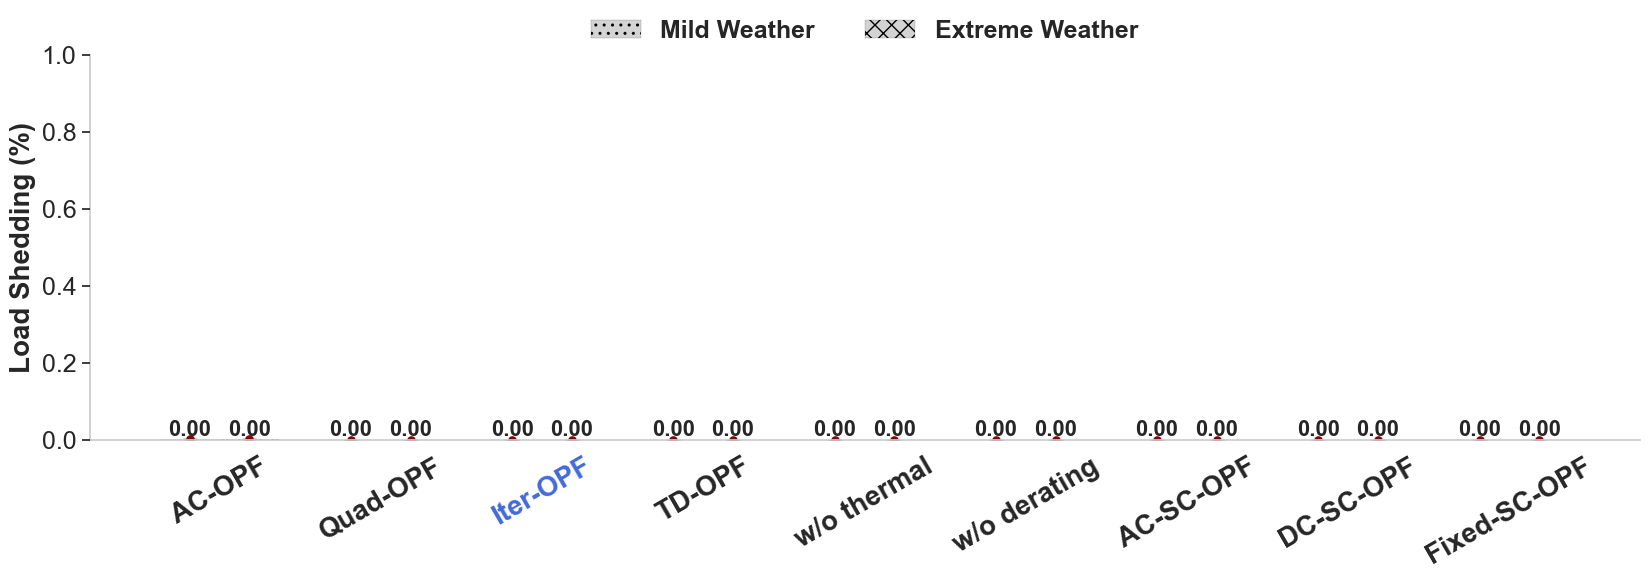

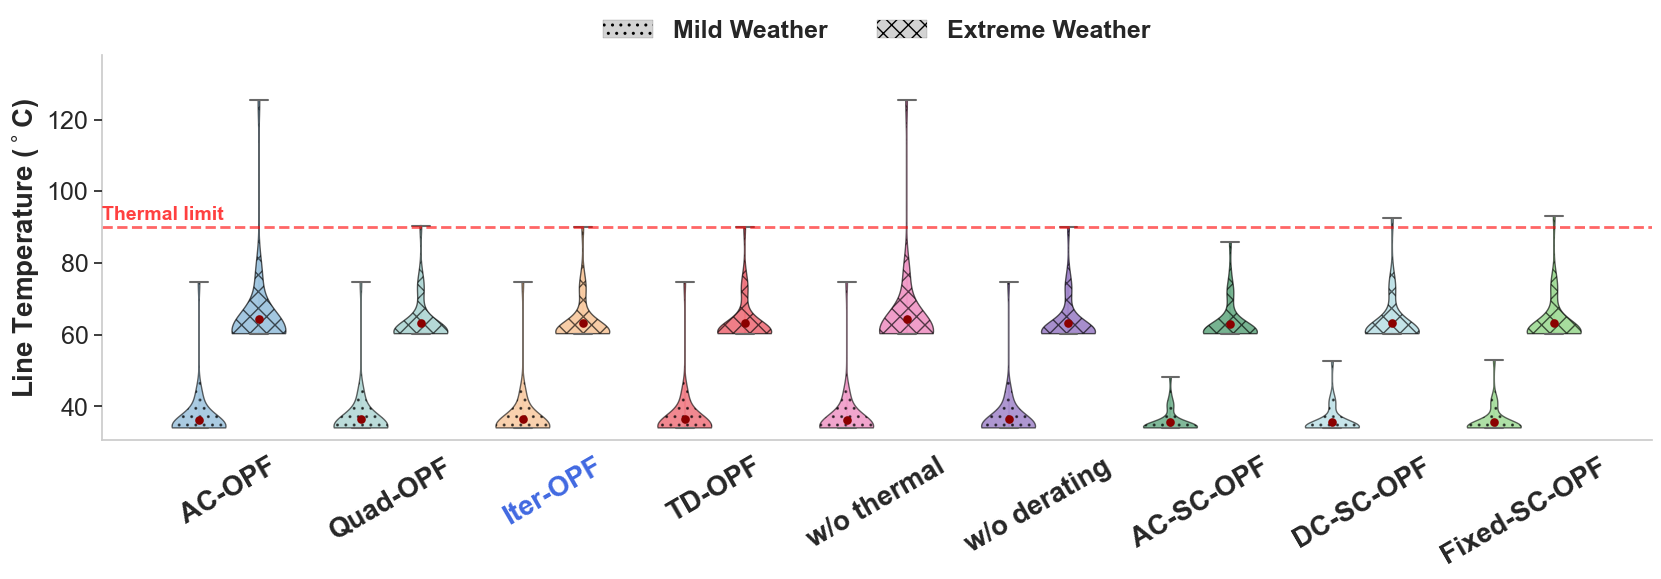

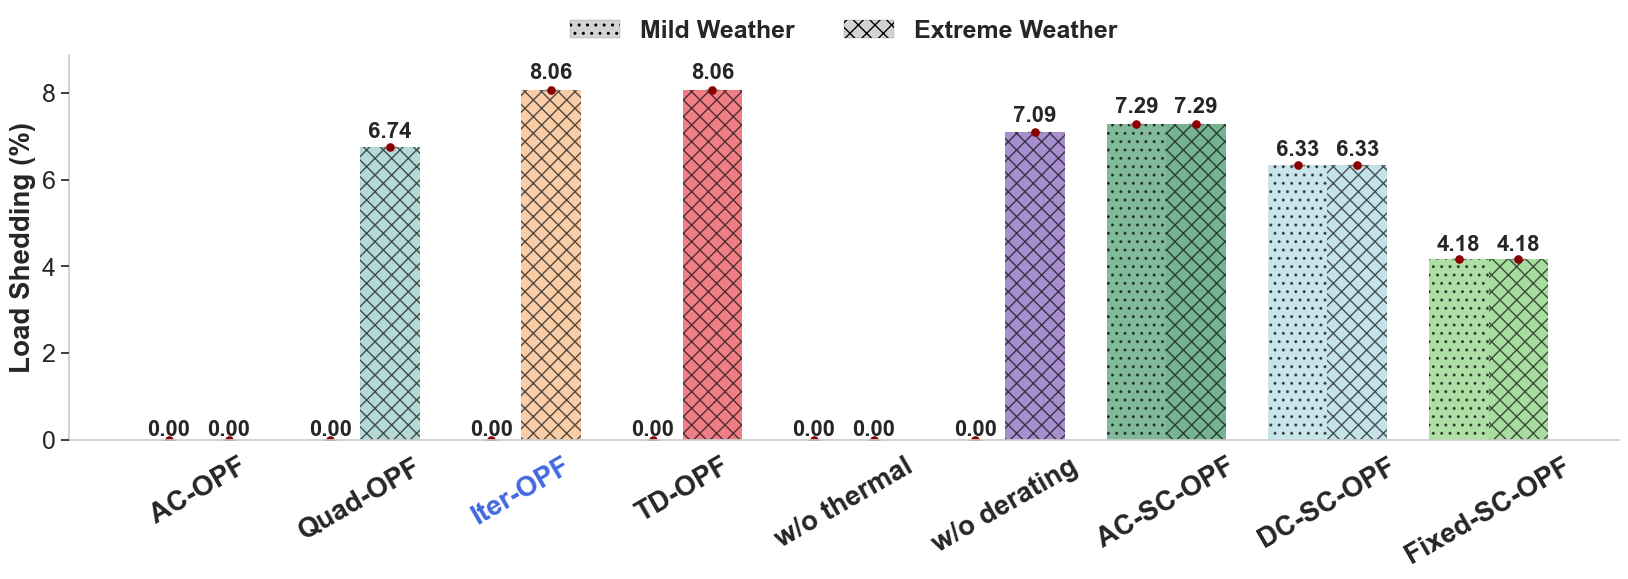

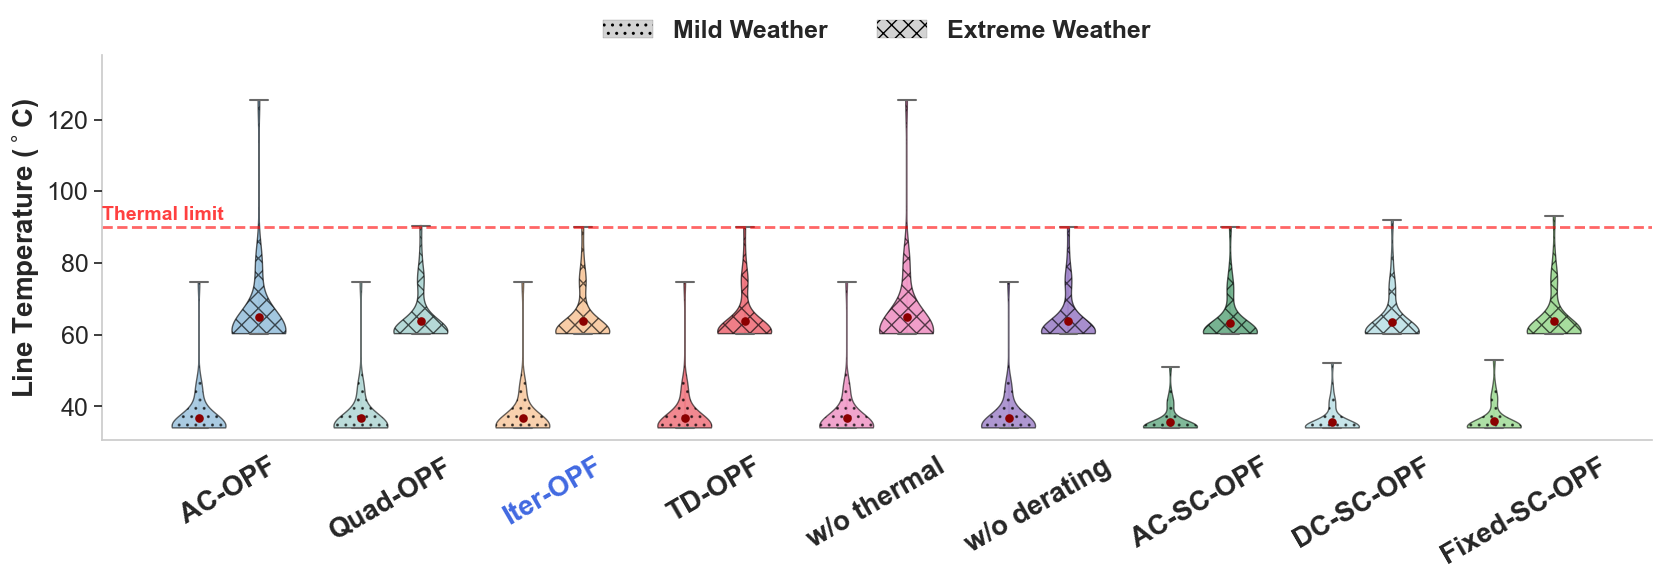

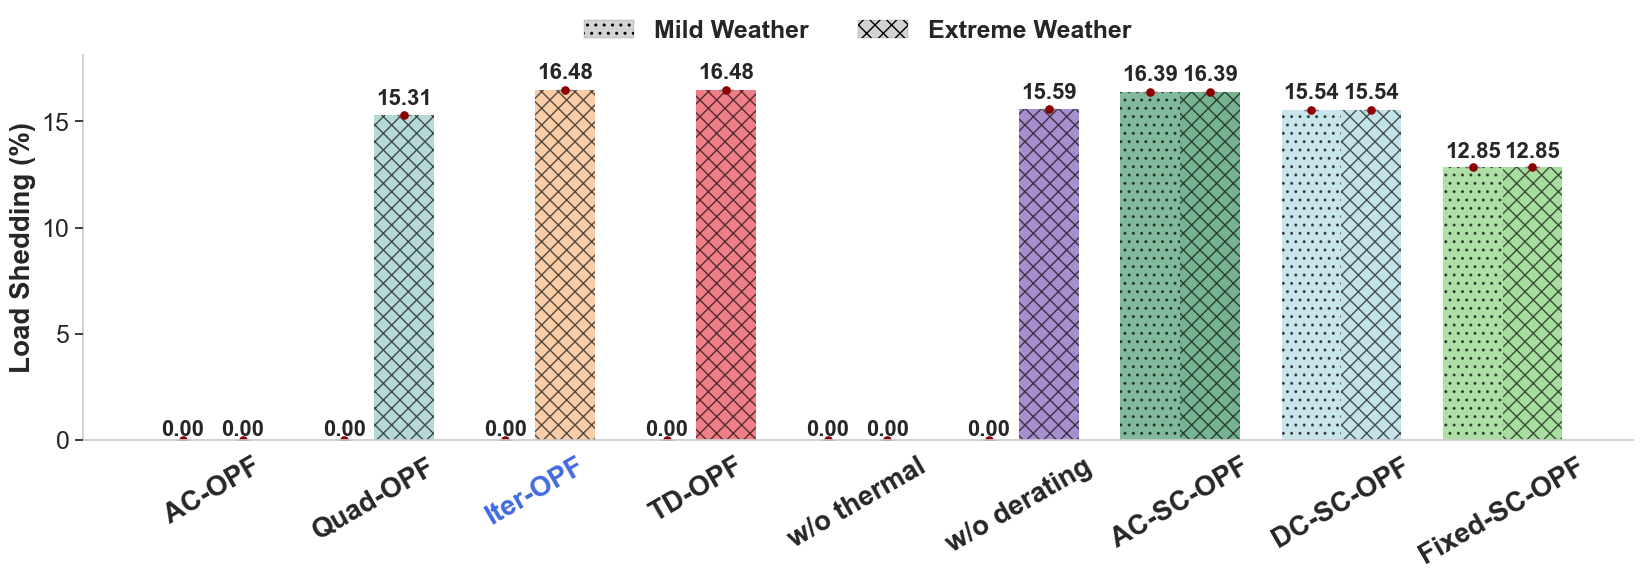

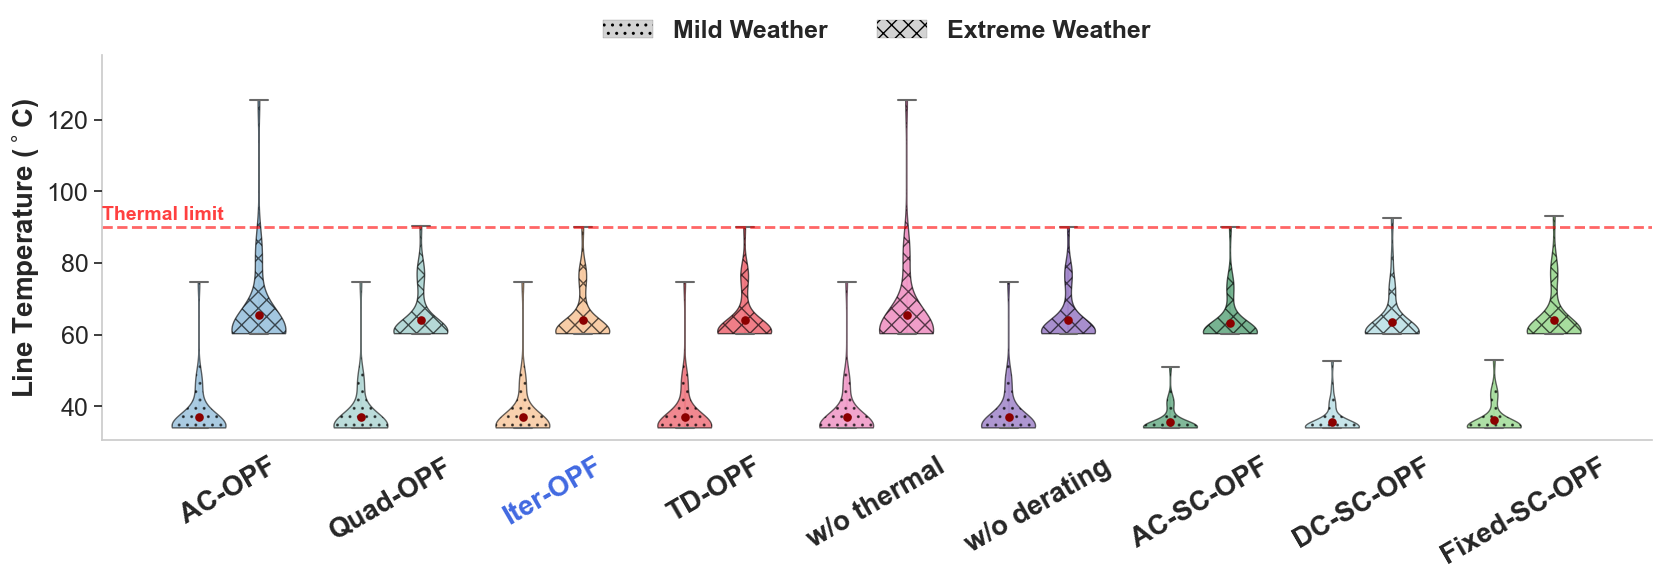

In [30]:
sensitivity_analysis_list = analysis_list + SA_list
analysis_label = [analysis_list_label[m] for m in sensitivity_analysis_list]
colors = [colors_list[m] for m in sensitivity_analysis_list]
scenario_labels = ['Mild Weather', 'Extreme Weather']

for load_ratio in Load_scenario:
    title = f'{load_ratio:.1f} Load Ratio'
    ls_mild, ct_mild, _, _ = get_data(
        mild_weather, load_ratio, sensitivity_analysis_list
    )
    ls_extreme, ct_extreme, _, _ = get_data(
        extreme_weather, load_ratio, sensitivity_analysis_list
    )

    # --- Load-shedding bar plot ---
    bar_data = {
        'Mild Weather':    (ls_mild, np.zeros_like(ls_mild)),
        'Extreme Weather': (ls_extreme, np.zeros_like(ls_extreme)),
    }
    grouped_bar_plot(
        bar_data, analysis_label, scenario_labels, colors,
        y_label='Load Shedding (%)', scenario_color='lightgray',
        label_rotation=30,
        save_path=(cur_dir
                   + f'/models/IEEE30/sensitivity_analysis'
                   + f'/SA_load_shedding_{title}.pdf'),
    )

    # --- Temperature violin plot ---
    violin_data = {
        'Mild Weather':    [ct_mild[i].flatten()
                            for i in range(len(sensitivity_analysis_list))],
        'Extreme Weather': [ct_extreme[i].flatten()
                            for i in range(len(sensitivity_analysis_list))],
    }
    grouped_violin_plot(
        violin_data, analysis_label, scenario_labels, colors,
        y_label=r'Line Temperature ($^\circ$C)', scenario_color='lightgray',
        label_rotation=30,
        save_path=(cur_dir
                   + f'/models/IEEE30/sensitivity_analysis'
                   + f'/SA_temp_dist_{title}.pdf'),
    )

## 6. Computational Cost Comparison

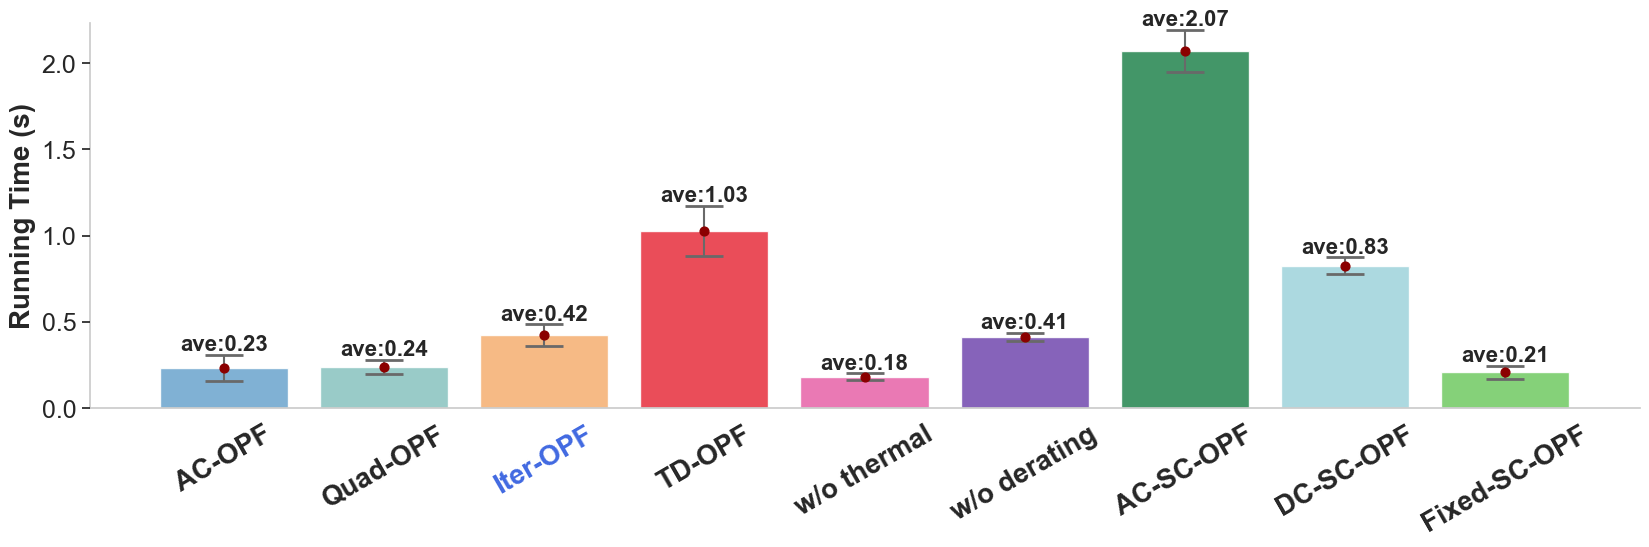

In [31]:
run_time_data = get_comp_cost_data(sensitivity_analysis_list)

single_bar_plot(
    run_time_data, analysis_label, colors,
    y_label='Running Time (s)', label_rotation=30,
    save_path=cur_dir + '/models/IEEE30/sensitivity_analysis/SA_run_time.pdf',
)

## 7. Weather-Scenario Analysis

Compare a subset of methods across all four weather scenarios at heavy
load (1.0).

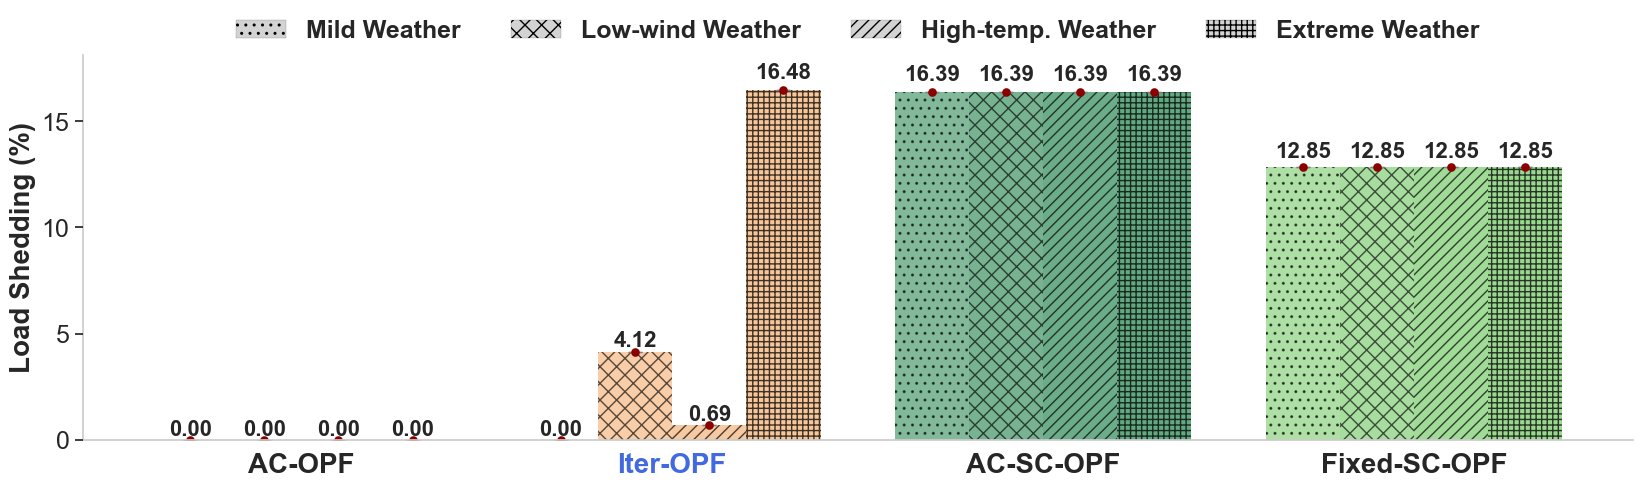

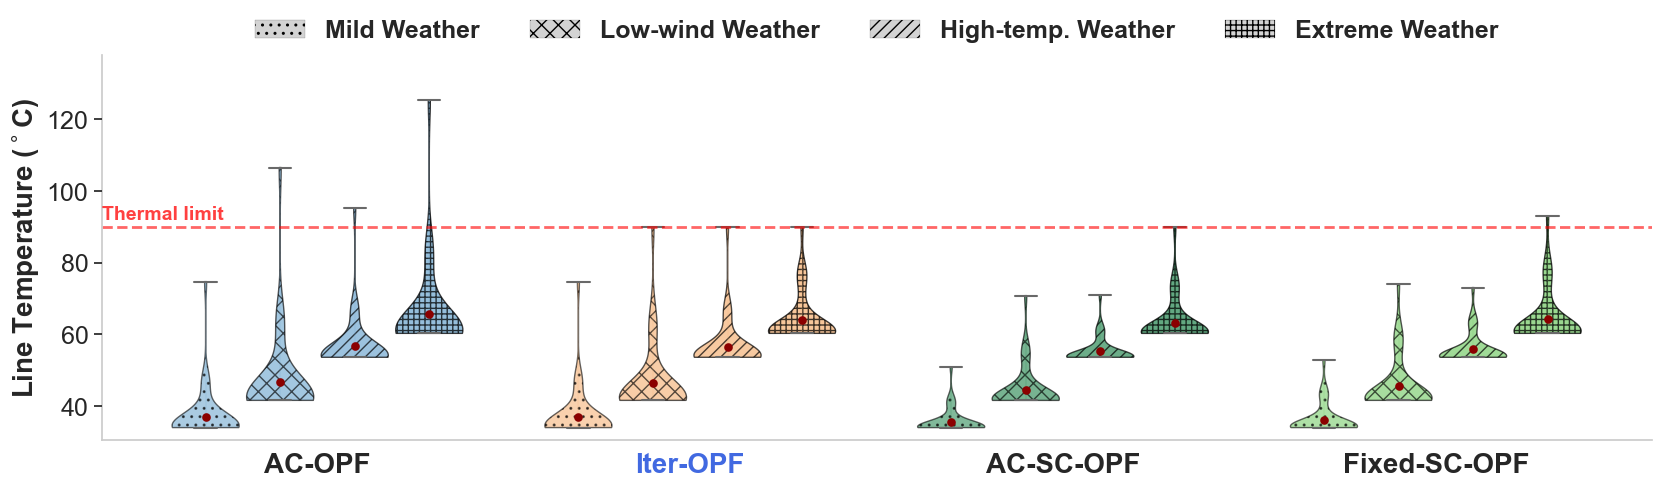

In [32]:
sensitivity_analysis_list = (
    analysis_list[0:1] + analysis_list[2:3] + [SA_list[2], SA_list[4]]
)
analysis_label = [analysis_list_label[m] for m in sensitivity_analysis_list]
colors = [colors_list[m] for m in sensitivity_analysis_list]

scenario_labels = [
    'Mild Weather', 'Low-wind Weather',
    'High-temp. Weather', 'Extreme Weather',
]

load_ratio = 1.0
max_temp = 90

con_temp_data_list = []
load_shedding_data_list = []
for weather in Weather_scenario:
    ls, ct, _, _ = get_data(
        weather, load_ratio, sensitivity_analysis_list,
        max_conductor_temp=max_temp,
    )
    con_temp_data_list.append(ct)
    load_shedding_data_list.append(ls)

title = f'{load_ratio:.1f} Load Ratio'
n_methods = len(sensitivity_analysis_list)

# --- Load-shedding bar plot ---
bar_data = {
    label: (load_shedding_data_list[i],
            np.zeros_like(load_shedding_data_list[i]))
    for i, label in enumerate(scenario_labels)
}
grouped_bar_plot(
    bar_data, analysis_label, scenario_labels, colors,
    y_label='Load Shedding (%)', scenario_color='lightgray',
    bar_width=0.2,
    save_path=(cur_dir
               + f'/models/IEEE30/sensitivity_analysis'
               + f'/WA_load_shedding_{title}.pdf'),
)

# --- Temperature violin plot ---
violin_data = {
    label: [con_temp_data_list[i][j].flatten() for j in range(n_methods)]
    for i, label in enumerate(scenario_labels)
}
grouped_violin_plot(
    violin_data, analysis_label, scenario_labels, colors,
    y_label=r'Line Temperature ($^\circ$C)', scenario_color='lightgray',
    bar_width=0.2,
    save_path=(cur_dir
               + f'/models/IEEE30/sensitivity_analysis'
               + f'/WA_temp_dist_{title}.pdf'),
)